# Milestone P4 - A comparative approach on chilling effect, from Wikipedia to Google Trend

## Course CS-401 - Applied Data Analysis

### Instructor : [Robert West](https://dlab.epfl.ch/people/west/)

### Author :  
- **Chraibi Ghali**  
    SCIPER: 262251
- **Jesslen Artur**  
    SCIPER: 270642
- **Michels Luc**  
    SCIPER: ????????????  

#### Due date: 18 Dec 2020

---
### Context

Lorem ipsum

### Data

Lorem ipsum

### Imports

In [10]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np

from os import path

---
### Replicate the experiment of the paper

#### Load data

In [2]:
data_path = 'data/'

if path.exists(data_path):
    terrorism_df = pd.read_pickle(data_path+"terrorism.pkl")
    domestic_df = pd.read_pickle(data_path+"domestic.pkl")
    top_30_terrorism_df = pd.read_pickle(data_path+"top_30_terrorism.pkl")
else:
    raise NotADirectoryError

In [3]:
terrorism_df = terrorism_df[['date', 'max_ratio', 'topic_name']]
print(terrorism_df.shape)
terrorism_df.head(5)

(6020, 3)


,date,max_ratio,topic_name
0,2012-01-01,1.033386,Al-Qaeda
1,2012-01-08,1.192369,Al-Qaeda
2,2012-01-15,1.271860,Al-Qaeda
3,2012-01-22,1.192369,Al-Qaeda
4,2012-01-29,1.192369,Al-Qaeda


#### Analyse data

In [4]:
# Define a constant for the date of revelation
revelation_date = pd.Timestamp('2013-06-15')

In [5]:
# Organise the data in a time series with the ratio of total views per week
terrorism_ts = terrorism_df.groupby(by='date').sum()
terrorism_ts = terrorism_ts.reset_index().rename(columns={'index': 'date'})

# Separate the data in two to perform an ITS analysis
terrorism_pre_june_ts = terrorism_ts[terrorism_ts['date'] < revelation_date]
terrorism_post_june_ts = terrorism_ts[terrorism_ts['date'] > revelation_date]

Step 1

In [6]:
print(np.mean(terrorism_pre_june_ts['max_ratio']))
print(np.mean(terrorism_post_june_ts['max_ratio']))
print(terrorism_post_june_ts.shape)
terrorism_pre_june_ts

144.39245350898165
155.2993829143416
(64, 2)


,date,max_ratio
0,2012-01-01,147.268060
1,2012-01-08,169.352696
2,2012-01-15,148.067427
3,2012-01-22,149.562785
4,2012-01-29,162.182179
...,...,...
71,2013-05-12,153.738519
72,2013-05-19,152.116111
73,2013-05-26,144.090906
74,2013-06-02,132.843838


In [ ]:
# TODO Histogram

Step 2

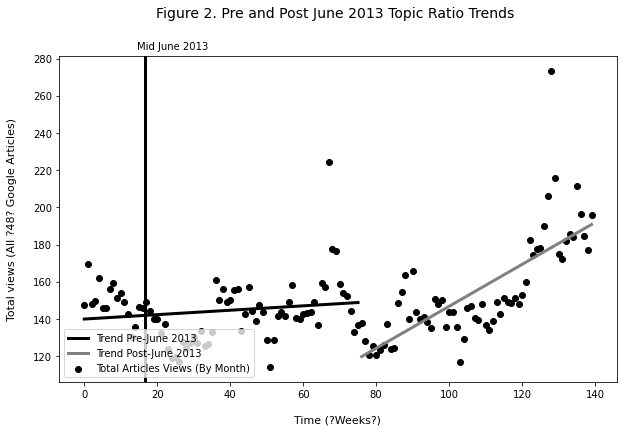

In [28]:
### TODO Modify description of the plot

# Visualisation of full time series
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('Figure 2. Pre and Post June 2013 Topic Ratio Trends \n\n', fontsize=14)
ax.set_xlabel('\nTime (?Weeks?)', fontsize=11)
ax.set_ylabel('Total views (All ?48? Google Articles)\n', fontsize=11)

ax.scatter(terrorism_ts.index, terrorism_ts['max_ratio'], label='Total Articles Views (By Month)', color='black')

# Draw the regressions
slope_pre_june, intercept_pre_june, _, _, _ = stats.linregress(terrorism_pre_june_ts.index, 
                                                               terrorism_pre_june_ts['max_ratio'])
slope_post_june, intercept_post_june, _, _, _ = stats.linregress(terrorism_post_june_ts.index,
                                                                 terrorism_post_june_ts['max_ratio'])
x1 = terrorism_pre_june_ts.index
ax.plot(x1, intercept_pre_june + slope_pre_june*x1, color='black', linewidth='3', label='Trend Pre-June 2013')
x2 = terrorism_post_june_ts.index
ax.plot(x2, intercept_post_june + slope_post_june*x2, color='gray', linewidth='3', label='Trend Post-June 2013')

# Emphasise when the revelations occured 
revelation_date_integer = 16.5
ax.axvline(x=revelation_date_integer, ymin=0, ymax=280, color='black', linewidth='3')

x_text_offset = 14.5
y_text_offset = 285
ax.text(x_text_offset, y_text_offset, 'Mid June 2013', fontsize=10)

ax.legend(loc='lower left')
plt.show()

Step 3 - Compare